In [1]:
import sys
import copy
sys.path.append('..')
import time
import numpy as np
import scipy as sp
import scipy.stats
import sklearn
#~import xgboost
#import xgboost
import sklearn
import explainers
from load_datasets import *
import glob
import argparse
import collections
from sklearn import ensemble
import pickle
import parzen_windows

from numpy import linalg as LA
from numpy import linalg as LA
import pandas as pd
from scipy import sparse
from scipy.sparse import dok_matrix
import time
from time import gmtime, strftime
import sys
import math

from scipy.spatial import distance_matrix
from  scipy.spatial.distance import squareform,pdist
sys.path.append('..')
import random

In [2]:
nbr_top =3

In [3]:
class_names = ['pos', 'neg']



def toMatrix(exps,explainer):
    
    list_features= set() 
    for instance, _ in exps[explainer]:
        for feature,_ in instance:
            list_features.add(feature)
    
   
    list_features= {feature:indice for (indice,feature) in enumerate(list_features)}
    #print('list_features', list_features)
    nbr_lines = len(exps[explainer])
    nbr_colonnes = len(list_features) 
    X=np.zeros((nbr_lines,nbr_colonnes))
    i=0
    for instance,_ in exps[explainer]:
        for feature,value in instance:
            X[i,list_features[feature]] =  np.abs(value)
        i=i+1   
    print('\n XX',X)
    print('\n shape X', X.shape)
    return {'X':X,'shape': X.shape,'features':list_features}



In [4]:
def scos(X,Z,lamda,beta,maxIt,convex,seed):

    # get dim information
    n=X.shape[0]
    m=X.shape[1]
    h=Z.shape[1]
    # Seed for reproductibility 
    np.random.seed(seed)
    # Initialisation
    W=np.random.rand(m,h)
    D_w = np.eye(m)
    B = np.zeros((h,n))
    D_b = np.eye(n)
    Iw =np.eye(m)
    Ib = np.eye(n)
    epsIt= 1e-3
    t=0
    loss=np.zeros(maxIt)
    # start timing
    start_time=time.time()

    
    while t < maxIt:
        # update W and B
    
        W = LA.inv((X.T@X)+lamda * D_w +epsIt * np.eye(m))  @ (X.T @(B.T+Z)) if convex else LA.inv( (X.T@X) + lamda * (D_w-Iw) + epsIt * np.eye(m)) @  (X.T@(B.T+Z))
        B = (X@W - Z).T @ (LA.inv( Ib+beta*D_b +epsIt * np.eye(n))).T if convex else (X @ W -Z ).T @ LA.inv(Ib + beta * (D_b-Ib) +epsIt * np.eye(n) ).T     
        
        # Update diagonal W
        W_diag_norm =  sparse.eye(m)* 0.5 * np.apply_along_axis(np.linalg.norm,1,W)
        D_w = W_diag_norm + epsIt;
        
       
        # Update diagonal B
        B_diag_norm = sparse.eye(n)* 0.5 * np.apply_along_axis(np.linalg.norm,1,B.T)
        D_b = B_diag_norm + epsIt;
        
        # Compute the Loss  Frob+ L21 W + L21 B
        
        # L 21 W 
        l_21_W=np.sum(np.apply_along_axis(np.linalg.norm, 1, W))
        
        # L 21 B
        l_21_B=np.sum(np.apply_along_axis(np.linalg.norm, 1, B))
        
        # Compute the Loss
        loss[t]= LA.norm(X@W-B.T-Z, 'fro') + lamda * l_21_W+ beta*l_21_B 
        t=t+1
        
    tmp = time.time()-start_time 
    return {'W':W,'B':B,'loss':loss,'time':tmp,'maxIt':maxIt,'lambda':lamda,'beta':beta,'epsIt':epsIt,'seed':seed}

In [5]:
def calculate_adja_K( k_choice,explanations_second,predictions):
    sigma =1
    K_modified =np.zeros((len(explanations_second), len(explanations_second)))
    if (k_choice ==1):  
        p= pdist(explanations_second, 'euclidean')
        k_modified= squareform([math.pow(math.e, - p[i]/(2 * sigma **2 ) ) for i in range(len(p)) ])
        k_modified=k_modified+np.eye(k_modified.shape[0])
#   if (k_choice ==2):  
# 	  for i in range (len(explanations_second)):
# 	    K_modified[i][i]= 1
# 	    for j in range (len(explanations_second)):
#              (predictions[i] < 0.50) and (predictions[j] < 0.50) or  (predictions[i] >= 0.50) and (predictions[j] >= 0.50) ):
#     	      K_modified[i][j]= 1
#     	      K_modified[j][i]= 1
#     	    else:
#     	      K_modified[i][j]= 0
#     	      K_modified[j][i]= 0              
    return k_modified

In [6]:
def scos_function (explanations_second,K_modified,lamda ,beta,maxIt,z_dim):
   # calculate Z 
    D,V = LA.eig(K_modified)
    Z=V[:,0:z_dim] # dim  choisir comme  hyper param
    results=scos(explanations_second,Z,lamda ,beta,maxIt,convex= True, seed =1)
    B_SCOS =results['B']
    W_scos= results['W']
    scores = np.apply_along_axis(np.linalg.norm,1,  B_SCOS.T)
    importantes= np.argsort( scores)
    return results, importantes
    

In [7]:
def scos_pick(pickled_map, explainer, B,k_choice, lamda, beta, maxIt, z_dim):
    predictions1 = pickled_map['predict_probas1']  
    predictions2 = pickled_map['predict_probas2']
    matrix1 =  toMatrix(pickled_map['exps1'],'lime') # to use just those generated via LIME not other algos
    matrix2 =  toMatrix(pickled_map['exps2'],'lime') 
    expla_matrix1 =  toMatrix(pickled_map['exps1'],'lime') ['X']
    expla_matrix2 =  toMatrix(pickled_map['exps2'],'lime') ['X']
    K_modified1 = np.zeros((len(expla_matrix1), len(expla_matrix1)))
    k_modified1 = calculate_adja_K ( k_choice,expla_matrix1,predictions1)
  
    K_modified2 = np.zeros((len(expla_matrix2), len(expla_matrix2)))
    k_modified2 = calculate_adja_K ( k_choice,expla_matrix2,predictions2)
    
    results1, importantes1 = scos_function (expla_matrix1 , K_modified1,lamda ,beta,maxIt, z_dim)
    results2, importantes2 = scos_function (expla_matrix2 , K_modified2, lamda ,beta,maxIt,z_dim)
    mat_instances1= results1['B']
    mat_instances2= results2['B']
    pick1 = []
    pick2 = []
    for i in range(B):
        pick1.append(importantes1[i])
        pick2.append(importantes2[i])
    return pick1, pick2, results1,results2,matrix1,matrix2

In [8]:
def scos_pick_pos(pickled_map, explainer, B,k_choice, lamda, beta, maxIt, z_dim):
    predictions1 = []  
    predictions2 = []
    matrix1_positive =  toMatrix(pickled_map['exps1'],'positive') # to use just those generated via LIME not other algos
    matrix2_positive =  toMatrix(pickled_map['exps2'],'positive') 
    expla_matrix1 =  matrix1_positive['X']
    expla_matrix2 =  matrix2_positive['X']
    K_modified1 = np.zeros((len(expla_matrix1), len(expla_matrix1)))
    k_modified1 = calculate_adja_K ( k_choice,expla_matrix1,predictions1)
  
    K_modified2 = np.zeros((len(expla_matrix2), len(expla_matrix2)))
    k_modified2 = calculate_adja_K ( k_choice,expla_matrix2,predictions2)
    
    results1, importantes1 = scos_function (expla_matrix1 , K_modified1,lamda ,beta,maxIt, z_dim)
    results2, importantes2 = scos_function (expla_matrix2 , K_modified2, lamda ,beta,maxIt,z_dim)
    mat_instances1= results1['B']
    mat_instances2= results2['B']
    pick1 = []
    pick2 = []
    for i in range(B):
        pick1.append(importantes1[i])
        pick2.append(importantes2[i])
    return pick1, pick2, results1,results2,matrix1_positive,matrix2_positive

In [9]:
def scos_pick_neg(pickled_map, explainer, B,k_choice, lamda, beta, maxIt, z_dim):
    predictions1 = []  
    predictions2 = []
    matrix1_positive =  toMatrix(pickled_map['exps1'],'negative') # to use just those generated via LIME not other algos
    matrix2_positive =  toMatrix(pickled_map['exps2'],'negative') 
    expla_matrix1 =  matrix1_positive['X']
    expla_matrix2 =  matrix2_positive['X']
    K_modified1 = np.zeros((len(expla_matrix1), len(expla_matrix1)))
    k_modified1 = calculate_adja_K ( k_choice,expla_matrix1,predictions1)
  
    K_modified2 = np.zeros((len(expla_matrix2), len(expla_matrix2)))
    k_modified2 = calculate_adja_K ( k_choice,expla_matrix2,predictions2)
    
    results1, importantes1 = scos_function (expla_matrix1 , K_modified1,lamda ,beta,maxIt, z_dim)
    results2, importantes2 = scos_function (expla_matrix2 , K_modified2, lamda ,beta,maxIt,z_dim)
    mat_instances1= results1['B']
    mat_instances2= results2['B']
    pick1 = []
    pick2 = []
    for i in range(B):
        pick1.append(importantes1[i])
        pick2.append(importantes2[i])
    return pick1, pick2, results1,results2,matrix1_positive,matrix2_positive

In [10]:
i=0

In [11]:
def find_untrustworthy(explainer, exps, instances, untrustworthy):
    found = set()
    for i in instances:
        if explainer in ['lime', 'parzen']:
            exp, mean = exps[i]
        else:
            exp = exps[i]
        found = found.union([x[0] for x in exp if x[0] in untrustworthy])
    return found

def tally_mistrust(explainer, exps, predict_probas, untrustworthy):
    trust_fn = lambda prev, curr: (prev > 0.5 and curr > 0.5) or (prev <= 0.5 and curr <= 0.5)
    trust_fn_all = lambda exp, unt: len([x[0] for x in exp if x[0] in unt]) == 0
    mistrust = 0
    for i in range(len(exps)):
        if explainer in ['lime', 'parzen']:
            exp, mean = exps[i]
            if explainer == 'lime':
                prev_tot = sum([x[1] for x in exp]) + mean
            elif explainer == 'parzen':
                prev_tot = mean
            tot = prev_tot - sum([x[1] for x in exp if x[0] in untrustworthy])
            if not trust_fn(tot, prev_tot):
                mistrust += 1
        else:
            exp = exps[i]
            if not trust_fn_all(exp, untrustworthy):
                mistrust += 1
    return mistrust 

In [12]:
got_right = lambda test1, test2, mistrust1, mistrust2: mistrust1 < mistrust2 if test1 > test2 else mistrust1 > mistrust2

## Functions used to plot 

In [13]:
cx= [3,7,12,17,23,28,34,40,46,52,59,64,68,73,76,83,86,92,97,102,106,112,117,122,128,132,17,144,149,155,160,167,171,177,182,187,192,197,202,206,210,216,220,225,230,235,240,245,250,255,260,265,270,275,280]
cy= [4,13,8,14,4,12,3,15,5,14,4,12,4,19,8,13,3,16,4,11,4,11,4,16,6,12,4,15,6,18,4,14,7,18,4,15,6,17,4,12,6,19,4,15,6,18,4,12,4,15,6,18,4,12,4,15,6,17,4,12,6,19,4,15,6,19,4,15,6,18,4,12,4,15,6,184,13,8,14,4,12,3,15,5,14,4,12,4,11,5,14,4,13,4,11,4,11,4,16,6,12,4,15,6,18,4,14,7,18]

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def points_within_circle(radius, number_of_points,
                         center
                         ):
    center_x, center_y = center
    r = radius * np.sqrt(np.random.random((number_of_points,)))
    
    theta = np.random.random((number_of_points,)) * 2 * np.pi
    x = center_x + r * np.cos(theta)
    y = center_y + r * np.sin(theta)
    return center_x, center_y, x, y



In [15]:
def plot_features(cx,cy,pos_names,neg_names):
    pos_x = []
    pos_y = []
    neg_x = []
    neg_y = []

    set_1 = set(pos_names)
    set_2 = set(neg_names)

    list_2_items_not_in_list_1 = list(set_2 - set_1)
    combined_list = pos_names + list_2_items_not_in_list_1

    i=0
    for f in combined_list:
        c1_x, c1_y,f1_x, f1_y = points_within_circle(1.05, 2,  (cx[i], cy[i]))
        pos_x.append(f1_x)
        pos_y.append(f1_y)
        i = i+1
        
    return combined_list, pos_x, pos_y


In [16]:
def draw_results(title,combined_list,cx,cy,pos_x,pos_y,names_features_chosen_submodular1_pos,names_features_chosen_submodular1_neg):    
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(len(combined_list)):
        ax.scatter(cx[i], 
        cy[i], 
        c="black", 
        label=combined_list[i],
        marker='')
        plt.text(cx[i]-1, cy[i]-0.6, combined_list[i], va='bottom', size='medium', color='black', weight='regular')



        if(combined_list[i] in names_features_chosen_submodular1_pos ):        
            point1= ax.scatter(pos_x[i][0], 
                    pos_y[i][0], 
                    c="b", 
                    marker='*')

        if(combined_list[i] in names_features_chosen_submodular1_neg ):        
            point2= ax.scatter(pos_x[i][1], 
                    pos_y[i][1], 
                    c="orange", 
                    marker='s')

    leg2 = ax.legend([point1,point2],['positive','negative'], loc='center right', bbox_to_anchor=(1, 0.5))
    ax.legend(loc='center left', bbox_to_anchor=(2, 0.5))
    # Manually add the first legend back
    ax.add_artist(leg2)
    #ax.title.set_text('Top 5 features from Submodular')
    #ax.grid()
    ax.grid(False)
    plt.axis('off')
    plt.savefig(title +".jpeg")
    plt.show()

## Apply SCOS and get results on one class at a time ( for now just on positive class)

In [17]:
output_folder = 'dvd0'
dataset = 'multi_polarity_dvd'
num_instances = 10
names = ['lime', 'parzen', 'random', 'greedy']
num_exps = 0
B = 10
rounds = 1
lamda = random.uniform(0.0, 100.0)
beta = random.uniform(0.0, 100.0)
z_dim =19100  # cghange Z according to p in the dataset 
maxIt =30
k_choice = 1
start_time = time.time()
pick_function_pos =  lambda a,b,c : scos_pick_pos(a,b,c, k_choice, lamda, beta, maxIt, z_dim)
pick_function_neg =  lambda a,b,c : scos_pick_neg(a,b,c, k_choice, lamda, beta, maxIt, z_dim)
accuracy = collections.defaultdict(lambda: [])
num_filez =0
i=0
right = collections.defaultdict(lambda: [])
matrix_lime1 = []
matrix_lime2 = []
for r in range(rounds):
    right = collections.defaultdict(lambda: [])
    for filez in glob.glob(os.path.join(output_folder, 'comparing_%s*' %dataset))[:800]:
        num_filez+=1            
        num_exps += 1
        pickled_map = pickle.load(open(filez,'rb'), encoding='latin1')
        ############
        vocabulary1407 = pickled_map['vocabulary']
        ###########
        true_label= pickled_map['true_labels']
        exps1_lime = pickled_map['exps1']['lime']
        exps2_lime = pickled_map['exps2']['lime']          
        exps1 = {}
        exps2 = {}
        exps1['positive'] = []
        exps2['positive'] = []
        exps1['negative'] = []
        exps2['negative'] = []
        for i in range (len(exps1_lime)):
            if ( true_label[i] == 1):
                exps1['positive'].append(exps1_lime[i])
                exps2['positive'].append(exps2_lime[i])
            if(true_label[i] == 0):
                exps1['negative'].append(exps1_lime[i])
                exps2['negative'].append(exps2_lime[i])

        new_pickled_map= {'exps1':exps1,'exps2': exps2}
        pick1_pos, pick2_pos, results1_positive, results2_positive, matrix_lime1_pos, matrix_lime2_pos = pick_function_pos(new_pickled_map, 'lime', B)
        pick1_neg, pick2_neg, results1_negative, results2_negative, matrix_lime1_neg, matrix_lime2_neg = pick_function_neg(new_pickled_map, 'lime', B)
        
        
#         liste_features1 = matrix_lime1['features']
#         liste_features2 = matrix_lime2['features']

# liste_features1


 XX [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 shape X (142, 589)

 XX [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 shape X (142, 657)

 XX [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 shape X (178, 733)

 XX [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 shape X (178, 742)


In [18]:
exps1['positive']

[([(129, 0.019184661412806534),
   (11528, -0.010499048222825047),
   (124, 0.005291111408245322),
   (9286, -0.0013073702650491395),
   (9728, -0.0008755279894381338),
   (12397, -0.0008506596965570906),
   (843, -0.000815276632804742),
   (10088, -0.0008065346636331103),
   (7910, -0.0007824008217638405),
   (19039, -0.0007424490743364536)],
  0.5304588304325223),
 ([(129, 0.018211253597367506),
   (11528, -0.009672961980470065),
   (11747, -0.005362213852226126),
   (9286, -0.004566897959985447),
   (6507, 0.0008429374855358599),
   (1570, 0.0001002923000855202),
   (126, 9.859969567396055e-05),
   (11946, 9.003434988420417e-05),
   (19039, 8.988506824773084e-05),
   (9478, 8.944036952749907e-05)],
  0.5199372007974012),
 ([(11784, -0.03366536890546917),
   (15069, 0.014911186437937037),
   (12702, 0.01084469287212418),
   (15439, 0.010191324655652681),
   (279, -0.008985598090750398),
   (11595, -0.00887615375306826),
   (310, 0.008019239943429277),
   (452, 0.005758148049611906),


In [19]:
exps1['negative']

[([(8177, -0.04387113507548149),
   (129, 0.026026038359006937),
   (9865, 0.01980963422509604),
   (18890, -0.017269865757168386),
   (1308, 0.0122300103707557),
   (18887, -0.01184705900915337),
   (11528, -0.009889719910621675),
   (10367, 0.006112305126336939),
   (133, 0.005968037685032517),
   (13314, -0.005408567308352614)],
  0.4813471368668068),
 ([(1308, -0.02605694105883766),
   (8005, 0.01708346698669403),
   (18890, -0.015329102793894062),
   (7085, 0.0018612937960176663),
   (15443, 0.0018352224053029163),
   (18864, 0.0018262846783219273),
   (17659, 0.0018198822723141685),
   (15712, 0.001773171668760118),
   (11624, 0.0017258829583471989),
   (12468, 0.0016195955774386606)],
  0.5046479259707222),
 ([(129, 0.02313958731371233),
   (7317, 0.01237385552059506),
   (13620, -0.004698420985227849),
   (3939, -0.002591189899142261),
   (17067, -0.002553267503385025),
   (18038, -0.0024350422526554444),
   (17583, -0.002359219519924146),
   (7282, -0.002320563711191141),
   (

In [20]:
results1_positive

{'W': array([[-0.03863174, -0.03858295, -0.03816937, ..., -0.03839909,
         -0.03837837, -0.03847332],
        [-0.03799376, -0.0379432 , -0.03753428, ..., -0.03775768,
         -0.03772997, -0.03782222],
        [-0.03720887, -0.03717258, -0.03694119, ..., -0.03720619,
         -0.03715218, -0.03720677],
        ...,
        [-0.03771787, -0.03767747, -0.03738686, ..., -0.03763897,
         -0.03759641, -0.03766516],
        [-0.03534324, -0.03528871, -0.03480545, ..., -0.03496235,
         -0.03497449, -0.03508317],
        [-0.03636097, -0.03631805, -0.03600841, ..., -0.03626066,
         -0.03621579, -0.0362808 ]]),
 'B': array([[-0.98729652,  0.01057475,  0.00383355, ...,  0.01146338,
          0.00361721,  0.00214743],
        [ 0.01159916, -0.98844501,  0.00378197, ...,  0.011396  ,
          0.00363335,  0.00213489],
        [ 0.01035408,  0.00927791, -0.99177766, ...,  0.01144806,
          0.00360691,  0.00219093],
        ...,
        [ 0.01048008,  0.00938808,  0.003983

In [21]:
results1_negative

{'W': array([[-0.02628481, -0.02549097, -0.02508963, ..., -0.02497581,
         -0.02527649, -0.02494395],
        [-0.00052693,  0.03322138,  0.05539588, ...,  0.06213261,
          0.03665102,  0.05972284],
        [-0.02633085, -0.02530811, -0.02516893, ..., -0.02509821,
         -0.02515451, -0.02508051],
        ...,
        [-0.02613266, -0.02559207, -0.0250137 , ..., -0.02491373,
         -0.02531815, -0.02483677],
        [-0.02676947, -0.02629735, -0.02574662, ..., -0.02567012,
         -0.02603089, -0.02559015],
        [-0.02630317, -0.02575722, -0.0251686 , ..., -0.02508453,
         -0.025464  , -0.02501531]]),
 'B': array([[-0.95685759,  0.01231209,  0.0051378 , ...,  0.00156384,
          0.0126158 ,  0.00529817],
        [ 0.01996869, -0.98320065,  0.00326998, ...,  0.00135654,
          0.01381343,  0.00339696],
        [ 0.02099314,  0.01139525, -0.99396648, ...,  0.00147041,
          0.01325017,  0.00328059],
        ...,
        [ 0.01905595,  0.01108485,  0.003090

In [22]:
W1_pos = results1_positive['W']
W2_pos = results2_positive['W']
W1_neg = results1_negative['W']
W2_neg = results2_negative['W']

In [23]:
W1_pos

array([[-0.03863174, -0.03858295, -0.03816937, ..., -0.03839909,
        -0.03837837, -0.03847332],
       [-0.03799376, -0.0379432 , -0.03753428, ..., -0.03775768,
        -0.03772997, -0.03782222],
       [-0.03720887, -0.03717258, -0.03694119, ..., -0.03720619,
        -0.03715218, -0.03720677],
       ...,
       [-0.03771787, -0.03767747, -0.03738686, ..., -0.03763897,
        -0.03759641, -0.03766516],
       [-0.03534324, -0.03528871, -0.03480545, ..., -0.03496235,
        -0.03497449, -0.03508317],
       [-0.03636097, -0.03631805, -0.03600841, ..., -0.03626066,
        -0.03621579, -0.0362808 ]])

In [24]:
W1_neg

array([[-0.02628481, -0.02549097, -0.02508963, ..., -0.02497581,
        -0.02527649, -0.02494395],
       [-0.00052693,  0.03322138,  0.05539588, ...,  0.06213261,
         0.03665102,  0.05972284],
       [-0.02633085, -0.02530811, -0.02516893, ..., -0.02509821,
        -0.02515451, -0.02508051],
       ...,
       [-0.02613266, -0.02559207, -0.0250137 , ..., -0.02491373,
        -0.02531815, -0.02483677],
       [-0.02676947, -0.02629735, -0.02574662, ..., -0.02567012,
        -0.02603089, -0.02559015],
       [-0.02630317, -0.02575722, -0.0251686 , ..., -0.02508453,
        -0.025464  , -0.02501531]])

In [25]:
W2_pos

array([[-0.03008501, -0.03031986, -0.03017704, ..., -0.03003171,
        -0.0295058 , -0.03026352],
       [-0.03138556, -0.03155783, -0.03146086, ..., -0.03130558,
        -0.03079064, -0.03152971],
       [-0.03150173, -0.03167601, -0.03157719, ..., -0.03142187,
        -0.03091131, -0.031646  ],
       ...,
       [-0.03115557, -0.03134492, -0.03124247, ..., -0.03108902,
        -0.03056292, -0.03130959],
       [-0.03134005, -0.03151282, -0.03141642, ..., -0.03126092,
        -0.03074529, -0.03148444],
       [-0.03154646, -0.03171589, -0.03162181, ..., -0.03146571,
        -0.03095122, -0.03168864]])

In [26]:
norm1_pos=np.sum(np.abs(W1_pos)**2,axis=-1)**(1./2)
norm2_pos=np.sum(np.abs(W2_pos)**2,axis=-1)**(1./2)
norm1_neg=np.sum(np.abs(W1_neg)**2,axis=-1)**(1./2)
norm2_neg=np.sum(np.abs(W2_neg)**2,axis=-1)**(1./2)

In [27]:
importantesW1_pos= np.argsort( -norm1_pos)
importantesW2_pos= np.argsort( -norm2_pos)
importantesW1_neg= np.argsort( -norm1_neg)
importantesW2_neg= np.argsort( -norm2_neg)
importantesW1_pos

array([ 43,  40, 393,  38, 381,  53,  35, 485,  36,  66,  49,  42,  94,
       389, 229, 443, 336, 221, 145,  98, 539, 394, 213, 125,  84, 537,
       534,  83, 513, 217, 352, 509, 463, 196, 142, 404, 271, 223, 359,
       248, 287, 237,  18, 343, 424, 230, 218,  71, 159, 448,   7, 425,
       163, 111, 279, 350, 204, 367,   0, 132, 529, 356,  82, 181, 202,
        73, 484, 418, 388, 473,  31, 158,  29, 386, 309, 175, 494, 242,
       528, 199, 526,  14, 371, 454, 292, 207, 300,  93, 245, 411, 189,
       286,  54, 530, 139, 173, 567, 578, 276,  26,  13, 415, 316, 251,
         6,  27, 131,   4, 226, 239, 320,  56,  69, 264,  75, 345, 334,
       121, 304, 584, 206, 572, 450, 176, 280,  52, 390,  65,  12,  60,
       470, 517, 347, 547, 332, 560, 269, 489, 452,  16, 192, 341, 339,
       130,  61, 525, 380, 190, 579,  55, 376, 519, 167,  30, 102, 170,
       263, 566, 503, 208,  91, 256, 162,  88, 553, 302, 212, 106, 549,
       502,  80, 532,  77, 501,  57, 373, 401, 488,  32, 507, 34

In [28]:
importantesW1_neg

array([495, 713, 724, 501, 193,  54, 714, 482,  68,  52,  57,  24,  49,
         1, 547,  50,  55, 155, 299, 284, 503,  58,  83,  53, 285, 270,
       212, 723, 283, 618, 367, 192, 322, 211, 218, 242, 385, 431, 276,
       424, 486, 370, 278, 348, 456, 718, 710, 488, 167, 709, 428, 186,
       393, 500, 246, 135, 106,  38, 114, 469, 523, 296, 295, 118, 716,
       177, 581, 264,  96, 120, 593, 119, 251, 254, 350, 390, 396, 293,
       152, 319, 154, 481, 560, 184, 669, 316,  79, 215, 672, 111, 204,
       688, 695, 219, 487, 583, 686, 447, 183,  30, 392, 697, 587, 465,
       600, 641, 676,  97, 274, 601,  34, 416, 706, 356, 508, 379, 532,
       698, 372,  14, 665, 206, 471, 181, 463, 557, 397,  66, 425, 387,
       731, 209,  22,  84, 326, 681, 725, 174,  26, 542, 225, 121, 614,
       298, 330, 603, 639, 677, 365, 306, 269, 317, 517, 265, 338, 137,
       169, 700, 703, 358, 671,  27, 520,  67, 452, 220, 227,  32, 536,
       599, 419, 266, 664, 168, 472, 553, 354, 491, 134, 654, 44

In [29]:
importantesW1_pos_top = []
importantesW2_pos_top = []
importantesW1_neg_top = []
importantesW2_neg_top = []
for i in range(nbr_top):
    importantesW1_pos_top.append(importantesW1_pos[i])
    importantesW2_pos_top.append(importantesW2_pos[i])
    importantesW1_neg_top.append(importantesW1_neg[i])
    importantesW2_neg_top.append(importantesW2_neg[i])
importantesW1_pos_top

[43, 40, 393]

In [30]:
liste_features1_pos = matrix_lime1_pos['features']
liste_features2_pos = matrix_lime2_pos['features']
liste_features2_pos

{6144: 0,
 10243: 1,
 18439: 2,
 18444: 3,
 6157: 4,
 8205: 5,
 17: 6,
 8212: 7,
 10261: 8,
 2069: 9,
 6167: 10,
 6169: 11,
 4127: 12,
 10274: 13,
 8228: 14,
 4135: 15,
 18475: 16,
 2095: 17,
 6194: 18,
 8243: 19,
 14392: 20,
 16440: 21,
 18491: 22,
 4155: 23,
 18493: 24,
 4159: 25,
 10305: 26,
 14402: 27,
 10307: 28,
 18498: 29,
 4162: 30,
 14405: 31,
 14404: 32,
 16456: 33,
 14411: 34,
 2123: 35,
 14412: 36,
 2127: 37,
 8273: 38,
 6226: 39,
 16466: 40,
 18522: 41,
 18524: 42,
 18528: 43,
 4195: 44,
 6245: 45,
 6250: 46,
 4204: 47,
 12397: 48,
 12408: 49,
 124: 50,
 125: 51,
 126: 52,
 127: 53,
 128: 54,
 129: 55,
 10367: 56,
 131: 57,
 132: 58,
 130: 59,
 133: 60,
 16512: 61,
 4228: 62,
 12425: 63,
 18567: 64,
 12424: 65,
 10386: 66,
 6291: 67,
 18581: 68,
 10389: 69,
 14486: 70,
 6301: 71,
 6307: 72,
 6139: 73,
 8360: 74,
 12461: 75,
 4275: 76,
 8372: 77,
 18611: 78,
 6326: 79,
 6327: 80,
 4280: 81,
 8376: 82,
 12468: 83,
 6333: 84,
 8382: 85,
 18629: 86,
 18631: 87,
 18633: 88,
 18

In [31]:
liste_features1_neg = matrix_lime1_neg['features']
liste_features2_neg = matrix_lime2_neg['features']
liste_features1_neg

{8192: 0,
 12295: 1,
 16391: 2,
 18439: 3,
 8203: 4,
 18443: 5,
 18444: 6,
 16402: 7,
 8211: 8,
 12308: 9,
 2069: 10,
 10261: 11,
 4119: 12,
 8216: 13,
 6169: 14,
 10270: 15,
 8224: 16,
 10274: 17,
 8228: 18,
 10278: 19,
 18475: 20,
 6191: 21,
 16434: 22,
 18483: 23,
 18484: 24,
 8243: 25,
 12342: 26,
 6199: 27,
 16440: 28,
 18488: 29,
 8248: 30,
 18491: 31,
 8252: 32,
 10301: 33,
 18493: 34,
 16447: 35,
 18498: 36,
 10314: 37,
 18507: 38,
 12366: 39,
 2127: 40,
 6231: 41,
 18522: 42,
 16476: 43,
 4190: 44,
 18528: 45,
 12397: 46,
 6256: 47,
 4209: 48,
 124: 49,
 125: 50,
 12414: 51,
 127: 52,
 10367: 53,
 129: 54,
 130: 55,
 131: 56,
 132: 57,
 133: 58,
 128: 59,
 126: 60,
 6273: 61,
 12425: 62,
 2185: 63,
 4234: 64,
 18571: 65,
 14476: 66,
 4241: 67,
 18581: 68,
 2200: 69,
 6298: 70,
 2204: 71,
 18589: 72,
 158: 73,
 14495: 74,
 16541: 75,
 12451: 76,
 16548: 77,
 169: 78,
 171: 79,
 12461: 80,
 16558: 81,
 2223: 82,
 12464: 83,
 2224: 84,
 4271: 85,
 18611: 86,
 12468: 87,
 8372: 88

In [32]:
key_list1_pos = list(liste_features1_pos.keys())
val_list1_pos = list(liste_features1_pos.values())
features_chosen1_pos= []
for i in importantesW1_pos_top:
    features_chosen1_pos.append(key_list1_pos[i])

key_list2_pos = list(liste_features2_pos.keys())
val_list2_pos = list(liste_features2_pos.values())
features_chosen2_pos= []
for i in importantesW2_pos_top:
    features_chosen2_pos.append(key_list2_pos[i])
    
key_list1_neg = list(liste_features1_neg.keys())
val_list1_neg = list(liste_features1_neg.values())
features_chosen1_neg= []
for i in importantesW1_neg_top:
    features_chosen1_neg.append(key_list1_neg[i])
    
key_list2_neg = list(liste_features2_neg.keys())
val_list2_neg = list(liste_features2_neg.values())
features_chosen2_neg= []
for i in importantesW2_neg_top:
    features_chosen2_neg.append(key_list2_neg[i])

In [33]:
features_chosen1_pos

[132, 129, 15660]

In [34]:
features_chosen1_neg

[1308, 14290, 8177]

In [35]:
key_list_names = list(vocabulary1407.keys())
val_list_names = list(vocabulary1407.values())
key_list_names

['raining',
 'hordes',
 'foul',
 'four',
 'woods',
 'preface',
 'woody',
 'jemma',
 'cyprus',
 'looking',
 'chatter',
 'scold',
 'originality',
 'outwit',
 'tingle',
 'demoted',
 'sputter',
 'tapion',
 'immature',
 'meadows',
 'sinking',
 'navigating',
 'discribed',
 'oceans',
 'hitchcock',
 'tantalizing',
 'leisurely',
 'stabbed',
 'bringing',
 'revelers',
 'basics',
 'liaisons',
 'grueling',
 'wooden',
 'matchthis',
 'brutish',
 'stereotypical',
 'shows',
 'commented',
 'woodey',
 'specially',
 'francesco',
 'scrapes',
 'valiant',
 'loathing',
 'inanimate',
 'errors',
 'thunder',
 'cooking',
 'hawksworth',
 'dialoge',
 'joely',
 'designing',
 'marching',
 'groupie',
 'succumb',
 'shocks',
 'pioneering',
 'housewarming',
 'china',
 'punks',
 'cult',
 'evolutionist',
 'natured',
 'incoherant',
 'saccarine',
 'kids',
 'uplifting',
 'elaborate',
 'controversy',
 'karin',
 'natures',
 'inliked',
 'criticism',
 'golden',
 'wheather',
 'replace',
 'unanswered',
 'stern',
 'endzone',
 'cocai

In [36]:
result = [i for i in key_list_names if i.startswith('FAK')]
result

['FAKE6FAKE',
 'FAKE4FAKE',
 'FAKE1FAKE',
 'FAKE3FAKE',
 'FAKE0FAKE',
 'FAKE7FAKE',
 'FAKE9FAKE',
 'FAKE8FAKE',
 'FAKE2FAKE',
 'FAKE5FAKE']

## Show features of (positive class) for exps1 ( first classifier)

In [37]:
key_list_names = list(vocabulary1407.keys())
val_list_names = list(vocabulary1407.values())
val_list_names


names_scos_pos1= []
for code in features_chosen1_pos:
    names_scos_pos1.append(key_list_names[code])
    print(code,key_list_names[code])

132 types
129 dinosaurs
15660 coal


## Show features of (negative class) for exps1 ( 1 st classifier)

In [38]:
names_scos_neg1= []
for code in features_chosen1_neg:
    names_scos_neg1.append(key_list_names[code])
    print(code,key_list_names[code])

1308 FAKE3FAKE
14290 cesar
8177 slaughter


### Plot Results Scos 1 st classifier

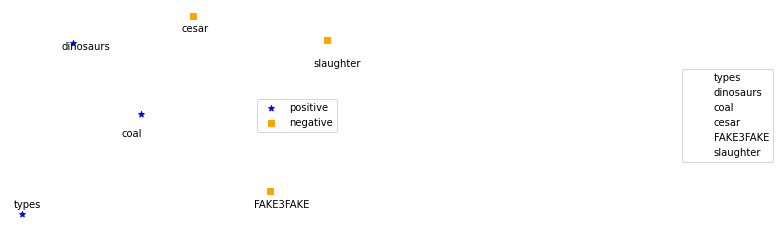

In [39]:
combined_list,pos_x, pos_y = plot_features(cx,cy,names_scos_pos1,names_scos_neg1)
title = 'scos1'
draw_results(title,combined_list,cx,cy,pos_x,pos_y,names_scos_pos1,names_scos_neg1)

## Show features of (positive class) for exps2 ( second classifier)

In [40]:
names_scos_pos2= []
for code in features_chosen2_pos:
    names_scos_pos2.append(key_list_names[code])
    print(code,key_list_names[code])

126 monroe
1683 cid
18475 crane


In [41]:
names_scos_pos2

['monroe', 'cid', 'crane']

## Show features of (negative class) for exps2 ( 2 nd classifier)

In [42]:
names_scos_neg2= []
for code in features_chosen2_neg:
    names_scos_neg2.append(key_list_names[code])
    print(code,key_list_names[code])

18483 associated
8042 strikingly
126 monroe


### Plot Results Scos 2 nd classifier

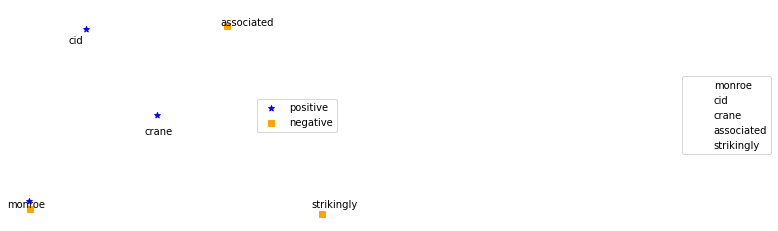

In [43]:
combined_list,pos_x, pos_y = plot_features(cx,cy,names_scos_pos2,names_scos_neg2)
title = 'scos2'
draw_results(title,combined_list,cx,cy,pos_x,pos_y,names_scos_pos2,names_scos_neg2)

## Get features names from Submodular one class at a time

In [44]:
# importing the module
import ast
  
  
# reading the data from the file
with open('features_submodu1807/dvd1/features_submodular_exps1_positiveout_d') as f:
    data1_pos = f.read()
with open('features_submodu1807/dvd1/features_submodular_exps1_positiveout_d') as f:
    data2_pos = f.read()
with open('features_submodu1807/dvd1/features_submodular_exps1_negative_out_d') as f:
    data1_neg = f.read()
with open('features_submodu1807/dvd1/features_submodular_exps2_negative_out_d') as f:
    data2_neg = f.read()
    
    
print("Data type before reconstruction : ", type(data1_pos))
# reconstructing the data as a dictionary
dct1_pos = ast.literal_eval(data1_pos)
dct2_pos = ast.literal_eval(data2_pos)
dct1_neg = ast.literal_eval(data1_neg)
dct2_neg = ast.literal_eval(data2_neg)
print(dct1_pos)  

Data type before reconstruction :  <class 'str'>
{18999: 0.03033791558261238, 18439: 0.07832747351173251, 18440: 0.023521251389861518, 6159: 0.033488197481495396, 8212: 0.1620348622364891, 10262: 0.12314324313635837, 6169: 0.011017223993201994, 6171: 0.02892154709625082, 17072: 0.028579546065515608, 8228: 0.03450091666084447, 10278: 0.03825774963399715, 4135: 0.04166232219775768, 10281: 0.026685125563822694, 18475: 0.5176247639183044, 8239: 0.03883499094299404, 8243: 0.27314564027235844, 16440: 0.030016288653740574, 14394: 0.010714005102841208, 18491: 0.037210554705528316, 18493: 2.8652860537297302e-09, 10305: 0.04751936498995783, 18498: 0.038176353899277114, 1718: 0.033720518558081544, 6216: 0.11934897917654823, 2121: 0.033278836808038774, 18506: 0.02923601178602772, 2123: 0.26185457515837535, 2127: 0.048109588993929135, 8273: 0.01928318986186116, 6226: 0.498322356838794, 6231: 0.027277722961962497, 15756: 0.02649517164901367, 18525: 0.04227014872223081, 18529: 0.21413282849883988, 21

In [45]:
print(dct2_pos) 

{18999: 0.03033791558261238, 18439: 0.07832747351173251, 18440: 0.023521251389861518, 6159: 0.033488197481495396, 8212: 0.1620348622364891, 10262: 0.12314324313635837, 6169: 0.011017223993201994, 6171: 0.02892154709625082, 17072: 0.028579546065515608, 8228: 0.03450091666084447, 10278: 0.03825774963399715, 4135: 0.04166232219775768, 10281: 0.026685125563822694, 18475: 0.5176247639183044, 8239: 0.03883499094299404, 8243: 0.27314564027235844, 16440: 0.030016288653740574, 14394: 0.010714005102841208, 18491: 0.037210554705528316, 18493: 2.8652860537297302e-09, 10305: 0.04751936498995783, 18498: 0.038176353899277114, 1718: 0.033720518558081544, 6216: 0.11934897917654823, 2121: 0.033278836808038774, 18506: 0.02923601178602772, 2123: 0.26185457515837535, 2127: 0.048109588993929135, 8273: 0.01928318986186116, 6226: 0.498322356838794, 6231: 0.027277722961962497, 15756: 0.02649517164901367, 18525: 0.04227014872223081, 18529: 0.21413282849883988, 2147: 0.0373922856733183, 6245: 0.04884591928178787

In [46]:
sorted_dict_positive1 = dict( sorted(dct1_pos.items(),
                           key=lambda item: item[1],
                           reverse=True))
sorted_dict_positive2 = dict( sorted(dct2_pos.items(),
                           key=lambda item: item[1],
                           reverse=True))
sorted_dict_negative1 = dict( sorted(dct1_neg.items(),
                           key=lambda item: item[1],
                           reverse=True))
sorted_dict_negative2 = dict( sorted(dct2_neg.items(),
                           key=lambda item: item[1],
                           reverse=True))


In [47]:
key_submodular1_pos = list(sorted_dict_positive1.keys())
top_submodular1_pos = []
for i in range(nbr_top):
    top_submodular1_pos.append(key_submodular1_pos[i])
top_submodular1_pos

[11584, 10088, 8042]

In [48]:
key_submodular2_pos = list(sorted_dict_positive2.keys())
top_submodular2_pos = []
for i in range(nbr_top):
    top_submodular2_pos.append(key_submodular2_pos[i])
top_submodular2_pos

[11584, 10088, 8042]

In [49]:
key_submodular1_neg = list(sorted_dict_negative1.keys())
top_submodular1_neg = []
for i in range(nbr_top):
    top_submodular1_neg.append(key_submodular1_neg[i])
top_submodular1_neg

[11584, 18890, 11528]

In [50]:
key_submodular2_neg = list(sorted_dict_negative2.keys())
top_submodular2_neg = []
for i in range(nbr_top):
    top_submodular2_neg.append(key_submodular2_neg[i])
top_submodular2_neg

[125, 11528, 5276]

## Show features of (positive class) for exps1 ( first classifier)

In [51]:
names_features_chosen_submodular1_pos= []
for code in top_submodular1_pos:
    names_features_chosen_submodular1_pos.append(key_list_names[code])
    print(code,key_list_names[code])
names_features_chosen_submodular1_pos

11584 superhero
10088 attic
8042 strikingly


['superhero', 'attic', 'strikingly']

## Show features of (positive class) for exps2 ( second classifier)

In [52]:
names_features_chosen_submodular2_pos= []
for code in top_submodular2_pos:
    names_features_chosen_submodular2_pos.append(key_list_names[code])
    print(code,key_list_names[code])
#names_features_chosen

11584 superhero
10088 attic
8042 strikingly


In [53]:
names_features_chosen_submodular2_pos

['superhero', 'attic', 'strikingly']

## Show features of (negative class) for exps1 ( first classifier)

In [54]:
names_features_chosen_submodular1_neg= []
for code in top_submodular1_neg:
    names_features_chosen_submodular1_neg.append(key_list_names[code])
    print(code,key_list_names[code])
#names_features_chosen

11584 superhero
18890 chutes
11528 persistence


## Show features of (negative class) for exps2 ( second classifier)

In [55]:
names_features_chosen_submodular2_neg= []
for code in top_submodular2_neg:
    names_features_chosen_submodular2_neg.append(key_list_names[code])
    print(code,key_list_names[code])
#names_features_chosen

125 dangerfield
11528 persistence
5276 commentaries


## Submodular Plot features results 1 st Classif

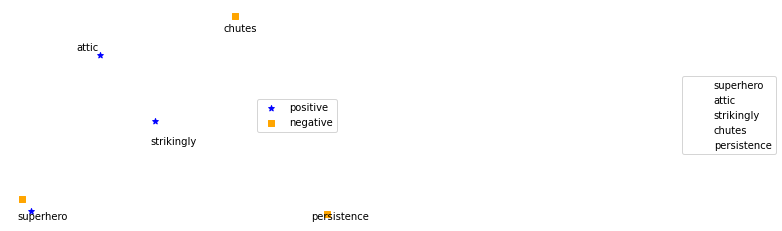

In [56]:
combined_list,pos_x, pos_y = plot_features(cx,cy,names_features_chosen_submodular1_pos,names_features_chosen_submodular1_neg)
title = 'sub1'
draw_results(title,combined_list,cx,cy,pos_x,pos_y,names_features_chosen_submodular1_pos,names_features_chosen_submodular1_neg)

## Submodular Plot features results 2 nd Classif

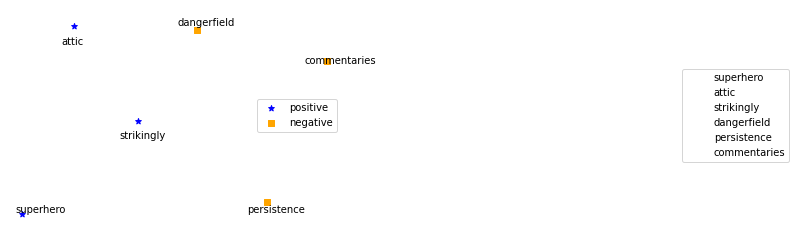

In [57]:
combined_list,pos_x, pos_y = plot_features(cx,cy,names_features_chosen_submodular2_pos,names_features_chosen_submodular2_neg)
title = 'sub2'
draw_results(title,combined_list,cx,cy,pos_x,pos_y,names_features_chosen_submodular2_pos,names_features_chosen_submodular2_neg)

In [58]:
key_list_names

['raining',
 'hordes',
 'foul',
 'four',
 'woods',
 'preface',
 'woody',
 'jemma',
 'cyprus',
 'looking',
 'chatter',
 'scold',
 'originality',
 'outwit',
 'tingle',
 'demoted',
 'sputter',
 'tapion',
 'immature',
 'meadows',
 'sinking',
 'navigating',
 'discribed',
 'oceans',
 'hitchcock',
 'tantalizing',
 'leisurely',
 'stabbed',
 'bringing',
 'revelers',
 'basics',
 'liaisons',
 'grueling',
 'wooden',
 'matchthis',
 'brutish',
 'stereotypical',
 'shows',
 'commented',
 'woodey',
 'specially',
 'francesco',
 'scrapes',
 'valiant',
 'loathing',
 'inanimate',
 'errors',
 'thunder',
 'cooking',
 'hawksworth',
 'dialoge',
 'joely',
 'designing',
 'marching',
 'groupie',
 'succumb',
 'shocks',
 'pioneering',
 'housewarming',
 'china',
 'punks',
 'cult',
 'evolutionist',
 'natured',
 'incoherant',
 'saccarine',
 'kids',
 'uplifting',
 'elaborate',
 'controversy',
 'karin',
 'natures',
 'inliked',
 'criticism',
 'golden',
 'wheather',
 'replace',
 'unanswered',
 'stern',
 'endzone',
 'cocai

In [59]:
def df_clusters (key,pos,neg):
    df_test = pd.DataFrame(columns = key, 
                   index = ['positive', 'negative'])
    
    for f in key:
        if ( f in pos):
            df_test.at['positive',f]=1
        if ( f in neg):
            df_test.at['negative',f]=1
    return df_test


new_df_clusters= df_clusters(key_list_names, names_features_chosen_submodular1_pos, names_features_chosen_submodular1_neg)
new_df_clusters

,raining,hordes,foul,four,woods,preface,woody,jemma,cyprus,looking,...,earthly,richardson,obscurations,priced,watanabe,insipid,rotting,jewel,emery,furthermore
positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
import numpy as np
import matplotlib.pyplot as plt

def points_within_circle(radius, number_of_points,
                         center
                         ):
    center_x, center_y = center
    r = radius * np.sqrt(np.random.random((number_of_points,)))
    
    theta = np.random.random((number_of_points,)) * 2 * np.pi
    x = center_x + r * np.cos(theta)
    y = center_y + r * np.sin(theta)
    return center_x, center_y, x, y



In [61]:
pos_x = []
pos_y = []
cpos_x = []
cpos_y = []
neg_x = []
neg_y = []
cneg_x = []
cneg_y = []
i = 2
j = 2


set_1 = set(names_features_chosen_submodular1_pos)
set_2 = set(names_features_chosen_submodular1_neg)

list_2_items_not_in_list_1 = list(set_2 - set_1)
combined_list = names_features_chosen_submodular1_pos + list_2_items_not_in_list_1


for f in combined_list:
    c1_x, c1_y,f1_x, f1_y = points_within_circle(2, 2,  (i, j))
    cpos_x.append(c1_x)
    cpos_y.append(c1_y)
    pos_x.append(f1_x)
    pos_y.append(f1_y)
        #i = i + random.randint(3,6)
        #j = j + random.randint(3,6)
    i = i + 4
    j = j + 6
    i = 2
    j = 2

combined_list
cpos_x

[2, 2, 2, 2, 2]

In [62]:
pos_x

[array([2.25998834, 2.4152739 ]),
 array([2.66441847, 1.36134564]),
 array([3.17919518, 2.52915194]),
 array([1.4884902 , 2.71355181]),
 array([2.08767568, 1.62070735])]

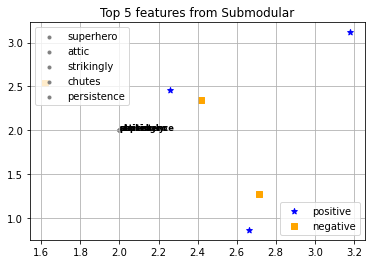

In [63]:
#X = np.arange(0, 8)
fig, ax = plt.subplots()


for i in range(len(combined_list)):
    ax.scatter(cpos_x[i], 
    cpos_y[i], 
    c="grey", 
    label=combined_list[i],
    marker='.')
    plt.text(cpos_x[i], cpos_y[i], combined_list[i], horizontalalignment='left', size='small', color='black', weight='semibold')

    
    
    if(combined_list[i] in names_features_chosen_submodular1_pos ):        
        point1= ax.scatter(pos_x[i][0], 
                pos_y[i][0], 
                c="b", 
                marker='*')
        
    if(combined_list[i] in names_features_chosen_submodular1_neg ):        
        point2= ax.scatter(pos_x[i][1], 
                pos_y[i][1], 
                c="orange", 
                marker='s')
#####################
           

# for i in range(len(names_features_chosen_submodular1_neg )):
#     if ( names_features_chosen_submodular1_neg[i] not in names_features_chosen_submodular1_pos):
        
#            ax.scatter(cneg_x[i], 
#                            cneg_y[i], 
#                            c="black", 
#                            label=names_features_chosen_submodular1_neg[i],
#                           marker='o')
#            plt.text(cneg_x[i], cneg_y[i], names_features_chosen_submodular1_neg[i], horizontalalignment='left', size='small', color='black', weight='semibold')

  
# for j in range(len(names_features_chosen_submodular1_neg )):
#     if ( names_features_chosen_submodular1_neg[i] not in names_features_chosen_submodular1_pos):
#          point2 = ax.scatter(neg_x[j][0], 
#                neg_y[j][0], 
#                c="orange", 
#               marker='s')
#     else:
#         idx =names_features_chosen_submodular1_pos. index(names_features_chosen_submodular1_neg[i])     
#         ax.scatter(pos_x[idx][1], 
#         pos_y[idx][1], 
#         c="orange", 
#         marker='s')

        
        
leg1 = ax.legend(loc='upper left')
# Add second legend for the maxes and mins.
# leg1 will be removed from figure
leg2 = ax.legend([point1,point2],['positive','negative'], loc='lower right')
# Manually add the first legend back
ax.add_artist(leg1)


ax.title.set_text('Top 5 features from Submodular')
ax.grid()
plt.show()

## Submodular plot but changing manually centers of features

In [64]:
cx= [3,2,5,6,8,10,12,14,15,16,17,18,19,20,21]
cy= [3,8,7,10,3,9,4,8,3,6,3,9,2,10,3,7,2,11]
pos_x = []
pos_y = []
neg_x = []
neg_y = []


set_1 = set(names_features_chosen_submodular1_pos)
set_2 = set(names_features_chosen_submodular1_neg)

list_2_items_not_in_list_1 = list(set_2 - set_1)
combined_list = names_features_chosen_submodular1_pos + list_2_items_not_in_list_1

i=0
for f in combined_list:
    c1_x, c1_y,f1_x, f1_y = points_within_circle(1.05, 2,  (cx[i], cy[i]))
    pos_x.append(f1_x)
    pos_y.append(f1_y)
    i = i+1

cx
pos_x

[array([2.77717982, 3.78458167]),
 array([1.12107951, 2.19796454]),
 array([4.5851791 , 5.10892055]),
 array([6.84181894, 5.19666089]),
 array([7.81991357, 8.58830088])]

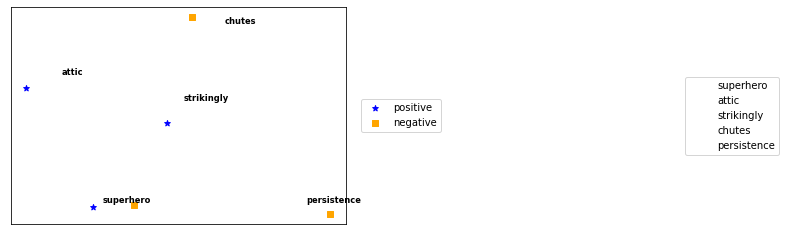

In [65]:
#X = np.arange(0, 8)
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])

for i in range(len(combined_list)):
    ax.scatter(cx[i], 
    cy[i], 
    c="black", 
    label=combined_list[i],
    marker='')
    plt.text(cx[i], cy[i], combined_list[i], horizontalalignment='left', size='small', color='black', weight='semibold')

    
    
    if(combined_list[i] in names_features_chosen_submodular1_pos ):        
        point1= ax.scatter(pos_x[i][0], 
                pos_y[i][0], 
                c="b", 
                marker='*')
        
    if(combined_list[i] in names_features_chosen_submodular1_neg ):        
        point2= ax.scatter(pos_x[i][1], 
                pos_y[i][1], 
                c="orange", 
                marker='s')
#####################
           

# for i in range(len(names_features_chosen_submodular1_neg )):
#     if ( names_features_chosen_submodular1_neg[i] not in names_features_chosen_submodular1_pos):
        
#            ax.scatter(cneg_x[i], 
#                            cneg_y[i], 
#                            c="black", 
#                            label=names_features_chosen_submodular1_neg[i],
#                           marker='o')
#            plt.text(cneg_x[i], cneg_y[i], names_features_chosen_submodular1_neg[i], horizontalalignment='left', size='small', color='black', weight='semibold')

  
# for j in range(len(names_features_chosen_submodular1_neg )):
#     if ( names_features_chosen_submodular1_neg[i] not in names_features_chosen_submodular1_pos):
#          point2 = ax.scatter(neg_x[j][0], 
#                neg_y[j][0], 
#                c="orange", 
#               marker='s')
#     else:
#         idx =names_features_chosen_submodular1_pos. index(names_features_chosen_submodular1_neg[i])     
#         ax.scatter(pos_x[idx][1], 
#         pos_y[idx][1], 
#         c="orange", 
#         marker='s')

        
        
#leg1 = ax.legend(loc='upper left')
# Add second legend for the maxes and mins.
# leg1 will be removed from figure
leg2 = ax.legend([point1,point2],['positive','negative'], loc='center right', bbox_to_anchor=(1.3, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(2, 0.5))
# Manually add the first legend back
ax.add_artist(leg2)


#ax.title.set_text('Top 5 features from Submodular')
ax.grid()
plt.show()

## Previous trial without splitting classes to + and -

In [66]:
output_folder = 'vocab_generate'
dataset = 'multi_polarity_books'
num_instances = 10
names = ['lime', 'parzen', 'random', 'greedy']
num_exps = 0
B = 10
rounds = 1
    
rand = '-date-'+strftime("%Y-%m-%d-%H-%M-%S", gmtime()) 
filename2 = 'test_2_scosglobal'+str(dataset)+','+str(B)+rand
header2= "id,lamda, beta,random,greedy,parzen,lime"
# with open(filename2, 'a') as file:
#     file.write(header2)
#     file.write('\n')
cpt =0
while (cpt <1) :
    cpt += 1
    #lamda = math.pow(10,np.random.randint(-3,6) )   * np.random.random(
    #lamda = math.pow(10,random.randint(0,1) )   * random.random()
    lamda = random.uniform(0.0, 100.0)
    #beta  = math.pow(10,random.randint(0,1) )   * random.random
    beta = random.uniform(0.0, 100.0)
    z_dim =300  # cghange Z according to p in the dataset 
    maxIt =10
    k_choice = 1
    start_time = time.time()
    pick_function =  lambda a,b,c : scos_pick(a,b,c, k_choice, lamda, beta, maxIt, z_dim)
    #accuracy = run_explanation(rounds,output_folder, dataset,num_exps, names, pick_function,B, 'scos', num_instances, lamda, beta)
        
        
    exec_time = time.time() - start_time

    #print'\n exec_time: ' ,exec_time
    #-----------------------------------------------------------------------
     #filename = 'results_comparing/results_'+str(pick) +'_' + str(num_instances)+'-date-'+strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    rand = '-date-'+strftime("%Y-%m-%d-%H-%M-%S", gmtime()) 
    filename = 'test_2/scos'+','+str(lamda)+','+str(beta)+','+str(dataset)+','+str(B)+rand
    header= "Id,filename,random,greedy,parzen,lime"
      
#     with open(filename, 'a') as file:
#         file.write(header)
#         file.write('\n')

    accuracy = collections.defaultdict(lambda: [])
    num_filez =0
    i=0
    right = collections.defaultdict(lambda: [])
    matrix_lime1 = []
    matrix_lime2 = []
    for r in range(rounds):
        right = collections.defaultdict(lambda: [])
        for filez in glob.glob(os.path.join(output_folder, 'comparing_%s*' %dataset))[:800]:
            num_filez+=1            
            num_exps += 1
            pickled_map = pickle.load(open(filez,'rb'), encoding='latin1')
            predict_probas = pickled_map['predict_probas1']
            ############
            vocabulary1407 = pickled_map['vocabulary']
            ###########
            predict_probas2 = pickled_map['predict_probas2']
            test1 = pickled_map['test_acc1']
            test2 = pickled_map['test_acc2']
            untrustworthy = pickled_map['untrustworthy']
            for explainer in names:
                if explainer.startswith('lime'):
                    print('in lim')
                    pick1, pick2, results1, results2, matrix_lime1, matrix_lime2 = pick_function(pickled_map, 'lime', B)
                    print('matrxm',matrix_lime1)
                    liste_features1 = matrix1['features']
                    liste_features2 = matrix1['features']
                    exps1 = pickled_map['exps1']['lime']
                    exps2 = pickled_map['exps2']['lime']
              
            unt1 = find_untrustworthy(explainer, exps1, pick1, untrustworthy)
            unt2 = find_untrustworthy(explainer, exps2, pick2, untrustworthy)

            mistrust1 = tally_mistrust(explainer, exps1, predict_probas, unt1)
            mistrust2 = tally_mistrust(explainer, exps2, predict_probas2, unt2)
            while mistrust1 == mistrust2:
                mistrust1 = np.random.randint(0,10)                                             
                mistrust2 = np.random.randint(0,10)
                #results= results + ',' + int(got_right(test1, test2, mistrust1, mistrust2)) + ','
            right[explainer].append(int(got_right(test1, test2, mistrust1, mistrust2)))
        right['random_choice'].append(int(got_right(test1, test2, np.random.random(), np.random.random())))
        results=str(num_exps)+','+filez+','+str(np.mean(right['random']))+','+str(np.mean(right['greedy']))+','+str(np.mean(right['parzen']))+','+str(np.mean(right['lime']))
          
#         with open(filename, 'a') as file:
#             file.write(results)
#             file.write('\n') 

    for name in right:
        accuracy[name].append(np.mean(right[name]))
        
    #print('\n accuracy:', accuracy['lime'])
    #return accuracy
#---------------------------------------------------------------------------------------------------------------------



    results=str(cpt)+ ','+ str(lamda)+','+str(beta)+','+str(np.mean(accuracy['random']))+','+str(np.mean(accuracy['greedy']))+','+str(np.mean(accuracy['parzen']))+','+str(np.mean(accuracy['lime']))
#         with open(filename2, 'a') as file:
#             file.write(results)
#             file.write('\n')  

in lim

 XX [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 shape X (320, 1065)

 XX [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 shape X (320, 1162)

 XX [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 shape X (320, 1065)

 XX [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 shape X (320, 1162)
matrxm {'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'shape

NameError: name 'matrix1' is not defined

In [ ]:
matrix_lime1

In [ ]:
vocabulary1407

In [ ]:
 {k:v for (k,v) in matrix_lime1['features'].items()if int(k) > 19000 }


In [ ]:
W = results1['W']

In [ ]:
W

In [ ]:
W.shape

In [ ]:
norm=np.sum(np.abs(W)**2,axis=-1)**(1./2)
norm

In [ ]:
norm.shape

In [ ]:
nbr_top =25
importantesW_top = []
importantesW= np.argsort( -norm)
importantesW

In [ ]:
norm[244]

In [ ]:
norm[93]

In [ ]:
np.max(norm)

In [ ]:
for i in range(nbr_top):
    importantesW_top.append(importantesW[i])
importantesW_top

In [ ]:
liste_features1 = matrix_lime1['features']

In [ ]:
key_list = list(liste_features1.keys())
val_list = list(liste_features1.values())


In [ ]:
features_chosen= []
for i in importantesW_top:
    features_chosen.append(key_list[i])
features_chosen

In [ ]:
len(features_chosen)

In [ ]:
key_list_names = list(vocabulary1407.keys())
val_list_names = list(vocabulary1407.values())
val_list_names

In [ ]:
key_list_names[207]

## Selected top n features from W

In [ ]:
names_features_chosen= []
for code in features_chosen:
    names_features_chosen.append(key_list_names[code])
    print(code,key_list_names[code])
#names_features_chosen

In [ ]:
names_features_chosen

## Read the vocab generated 14/07 in vocab_generate

In [ ]:
features_chosen_sobmodular = [10240, 4097, 6146,6147]
names_features_chosen_submodular= []
for code in features_chosen_sobmodular:
    #names_features_chosen_submodular(key_list_names[code])
    print(code,key_list_names[code])
#names_features_chosen

## Finding top features with submodular LIME

In [ ]:
# importing the module
import ast
  
# reading the data from the file
with open('dict_sub') as f:
    data = f.read()
  
print("Data type before reconstruction : ", type(data))
# reconstructing the data as a dictionary
d = ast.literal_eval(data)
  
print("Data type after reconstruction : ", type(d))
print(d)  


In [ ]:
sorted_dict = dict( sorted(d.items(),
                           key=lambda item: item[1],
                           reverse=True))

sorted_dict

In [ ]:
key_submodular = list(sorted_dict.keys())
top_submodular = []
for i in range(nbr_top):
    top_submodular.append(key_submodular[i])
top_submodular

In [ ]:
names_features_chosen_submodular= []
for code in top_submodular:
    names_features_chosen_submodular.append(key_list_names[code])
    print(code,key_list_names[code])
#names_features_chosen